# Panda challenge exploratory data analysis

This notebook EDA is a mix of existing EDA notebooks in the Prostate cANcer graDe Assessment (PANDA) challenge hosted on [kaggle](https://www.kaggle.com/c/prostate-cancer-grade-assessment/overview). Note that this notebook is an accumulation of various other notebooks from the challenge:

1.https://www.kaggle.com/rohitsingh9990/panda-eda-better-visualization-simple-baseline   
2.https://www.kaggle.com/gpreda/panda-challenge-starting-eda   
3.https://www.kaggle.com/wouterbulten/getting-started-with-the-panda-dataset   
4.https://www.kaggle.com/tanulsingh077/prostate-cancer-in-depth-understanding-eda-model   
5.https://www.kaggle.com/wouterbulten/getting-started-with-the-panda-dataset   

The Gleason grading system is outlined in the figure below
<img src="https://murtagh.mhmedical.com/data/books/2471/murtagh7e_c114_f04.png">


## Gleason system and isup
Gleason system and isup grades. The Gleason score consist of two numbers of the most prevalent and less prevalent cancer, which can then be added together. This measurement implies that Gleason scores with the same total are not the same, i.e 7$\ne$7, due to the order of the most prevalant cancer, which is an important distinction. This grading system is outlined below. The ISUP grade is then computed from the Gleason score defined in the matrix below.
<img src="https://storage.googleapis.com/kaggle-media/competitions/PANDA/Screen%20Shot%202020-04-08%20at%202.03.53%20PM.png">
The target is to correctly classify the ISUP grades.

In [6]:
import numpy as np
import pandas as pd
import csv
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import skimage.io
from matplotlib import colors

import openslide # first conda install -c conda-forge openslide, then conda install -c bioconda openslide-python
# sys hack and import custom notebook utils for visualization
import sys
sys.path.insert(0,'../utils')
import os
import time
import PIL

from nb_utils import plot_count, plot_relative_distribution, print_slide_details, \
                     display_patches, pairwise_plot, display_masks, load_and_resize_image, load_and_resize_mask \
                     plot_distribution_grouped



ROOT_DIR = Path('..')
DATA_DIR = ROOT_DIR / Path('data')
# path to the training images themselves
IMG_DIR = DATA_DIR / Path('train_images')
MASK_DIR = DATA_DIR / Path('train_label_masks')

## Label distribution

In [36]:
# load the submission, train, and test csv files
ssdf = pd.read_csv(DATA_DIR / Path('sample_submission.csv'))
train_df = pd.read_csv(DATA_DIR / Path('train.csv')).set_index('image_id')
test_df = pd.read_csv(DATA_DIR / Path('test.csv')).set_index('image_id')

train_img_list = os.listdir(IMG_DIR)
train_label_masks_list = os.listdir(MASK_DIR)

print("sample subsmission shape {}".format(ssdf.shape))
print("train shape {}".format(train_df.shape))
print("test shape {}".format(test_df.shape))


sample subsmission shape (3, 2)
train shape (10616, 3)
test shape (3, 1)


In [8]:
# Print simple statistics
display(ssdf.head())
display(train_df.head())
display(test_df.head())

image_id  isup_grade
0  005700be7e06878e6605e7a5a39de1b2           0
1  005c6e8877caf724c600fdce5d417d40           0
2  0104f76634ff89bfff1ef0804a95c380           0

data_provider  isup_grade gleason_score
image_id                                                                
0005f7aaab2800f6170c399693a96917    karolinska           0           0+0
000920ad0b612851f8e01bcc880d9b3d    karolinska           0           0+0
0018ae58b01bdadc8e347995b69f99aa       radboud           4           4+4
001c62abd11fa4b57bf7a6c603a11bb9    karolinska           4           4+4
001d865e65ef5d2579c190a0e0350d8f    karolinska           0           0+0

data_provider
image_id                                      
005700be7e06878e6605e7a5a39de1b2       radboud
005c6e8877caf724c600fdce5d417d40    karolinska
0104f76634ff89bfff1ef0804a95c380       radboud

In [37]:
print(f"train image_id list: {train_df.index.to_series().nunique()}")
print(f"train image list: {len(train_img_list)}")
print(f"train label masks list: {len(train_label_masks_list)}")

train image_id list: 10616
train image list: 10616
train label masks list: 10516


The sample submission and test csv do not have any gleason scores (ofcourse), and consist of only 3 data points, but is not the exact test set which is hosted on kaggle.

Note that there are roughly 100 examples without masks in the training set.

### Stratification of label distributions
The labels are from several different institutions.
Moreover, we need to know the distribution of isup grade counts, and how they relate to the different categories of gleason scores, which can also be counted.


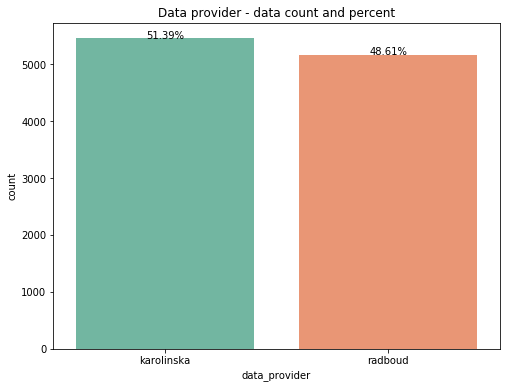

In [9]:
plot_count(train_df, 'data_provider', 'Data provider - data count and percent')


The contributions from each data provider seems to be fairly equal. This means there is no imbalance in the training set with respect to the data provider. This can be important, as clinics do not have homogenous processing steps for their WSI. 
   
We can now check for the ISUP grade total, as well as the ISUP grade scores from each data provider.

### ISUP grade & Gleason scores
The ISUP are the target variable for the challenge. But the Gleason scores are also heavily correlated with the ISUP grades.
By observing their distributions among different stratifications, such as their total counts per scores, and data providers, we can tell whether there is some kind of class imbalance in the target data. 

The first stratification will tell us if there is a class imbalance among the labels. The second stratification will tell us which data provider contributes how much to which label. This could be important, because if 90% of all ISUP grade > 3 comes from one data provider, and they both use different techniques for processing (staining), the results can become biased.

#### ISUP grades

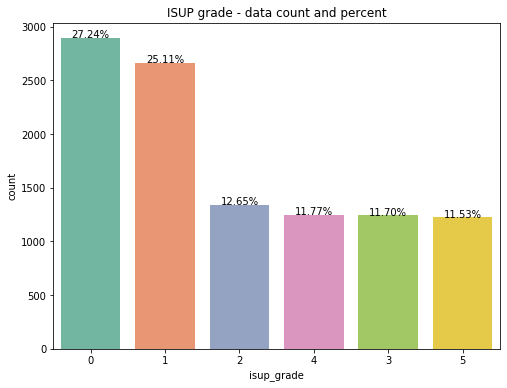

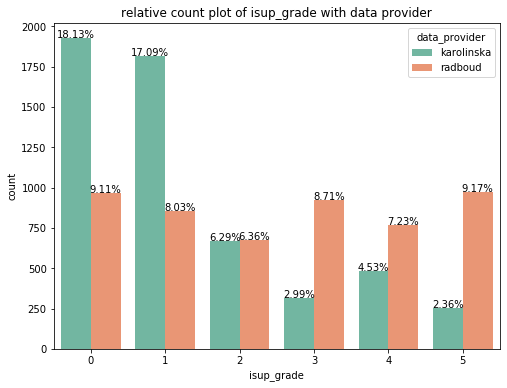

In [10]:
plot_count(train_df, 'isup_grade','ISUP grade - data count and percent', size=2)
plot_relative_distribution(train_df, feature='isup_grade', hue='data_provider', title='relative count plot of isup_grade with data provider', size=2)

The total counts per ISUP grades show us that there is a class imbalance, with classes [0,1] being majority classes, and [2,3,4,5] being minority classes. The inter group imbalance is quite low, i.e. there is no (severe) imbalance between classes [0,1], or within [2,3,4,5]. This shows that the majority has an ISUP grade of 0 (no cancer), or 1 (mild). 
   
In the relative distributions, the karolinska contributes more to the ISUP grades of [0,1], and thus providing more negative examples (no cancer) than radboud. The ISUP grade 2 is balanced well between the two providers. From ISUP grade 3 and onwards, Radboud provides more examples.
All in all it seems there is an imbalance between the providers among ISUP grades, which might have to be accounted for. The way this could possibly be done is through stain normalization or augmentation

#### Gleason scores

The Gleason scores are related to the ISUP grades and can provide further insight into the label distribution, albeit of a more secondary nature. The information in itself is richer, as it tells us the more prevalent Gleason scale, and the secondary prevalent Gleason grade. This could help us distinguish between possible ISUP grades, as the same ISUP grade does not imply the behaviour in the actual cells.

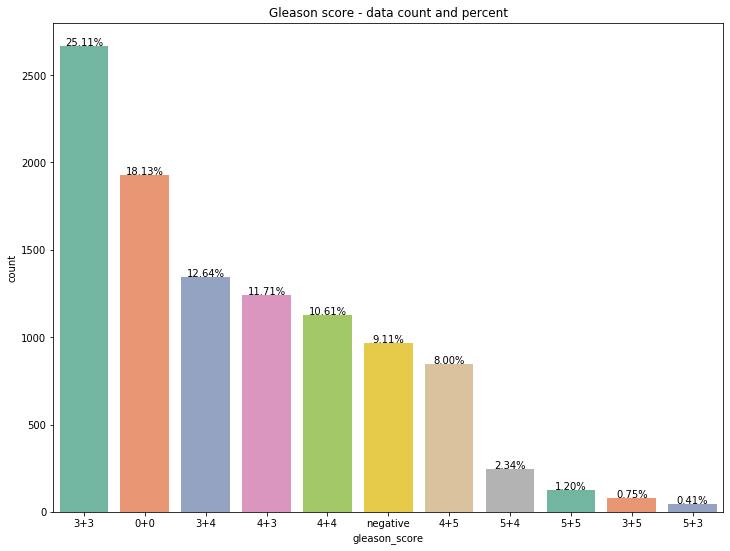

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


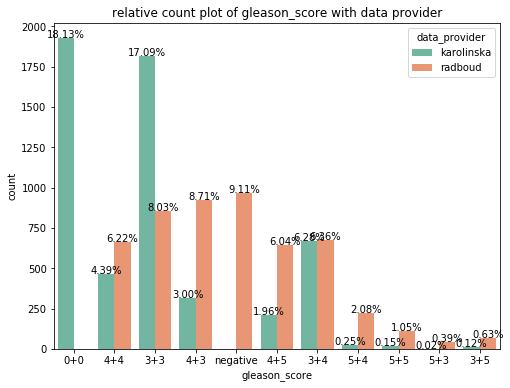

In [11]:
plot_count(train_df, 'gleason_score','Gleason score - data count and percent', size=3)
plot_relative_distribution(train_df, feature='gleason_score', hue='data_provider', title='relative count plot of gleason_score with data provider', size=2)

Again the inherent class imbalance is quite obvious and similar to the ISUP distribution: the negative and mild cases (ISUP [0,1]) are the majority classes, whereas the more severe cases are minority classes.  
Another notable observation is that 5+4, 5+5, 3+5, and 5+3 are quite uncommon in the dataset.
Question to myself: could it be that examples like 5+3 are 'actually' 5+4?

**Note:** The label 'negative' is derived from the radboud dataset, and is equivalent to the 0+0 in the karolinska dataset. Altogether, this will make the ISUP grade of 0 the majority class.

Finally we can also group the Gleason scores by their ISUP grades. 

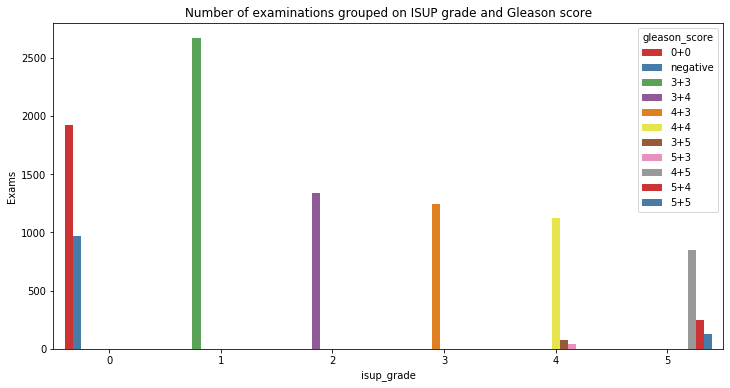

In [12]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6))
tmp = train_df.groupby('isup_grade')['gleason_score'].value_counts()
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
sns.barplot(ax=ax,x = 'isup_grade', y='Exams',hue='gleason_score',data=df, palette='Set1')
plt.title("Number of examinations grouped on ISUP grade and Gleason score")
plt.show()

inference:

* All exams with ISUP grade = 0 have Gleason score 0+0 or negative.
* All exams with ISUP grade = 1 have Gleason score 3+3.
* All exams with ISUP grade = 2 have Gleason score 3+4.
* All exams with ISUP grade = 3 have Gleason score 4+3.
* All exams with ISUP grade = 4 have Gleason score 4+4 (majority), 3+5 or 5+3.
* All exams with ISUP grade = 5 have Gleason score 4+5 (majority), 5+4 or 5+5.

### Label distribution conclusions:

1. There is a class imbalance in the labels, with ISUP grades [0,1] being the majority classes.
2. there is a data provider imbalance in the labels: radboud provides more ISUP > 3 examples, karolinska provides more ISUP [0,1] examples. The ISUP 2 examples are balanced among the providers.
3. The Gleason score distribution in relation to the ISUP grades show that there are several 1:1 (0,1, 2, 3), but ISUP grades 4 and 5 are composed of multiple Gleason score combinations.


## Image analysis
We still have the training/test images, as well as a file with masks. 
* How do these relate with the csv file? 
* what do they look like?
* how do they work in general?
* Why do we have masks and labels?
    * Can we use both sets of information for training to target interesting regions?
    
To answer these question, we can start easy by plotting images in a variety of ways (this will also help us further in other notebooks)

### Plotting image patch samples

Below we will show several examples on how to load WSI in several different ways.
The important thing here is that WSI can be loaded in different levels, which are downsampled version.
Image patches can also be extracted from any arbitrary level. 
   

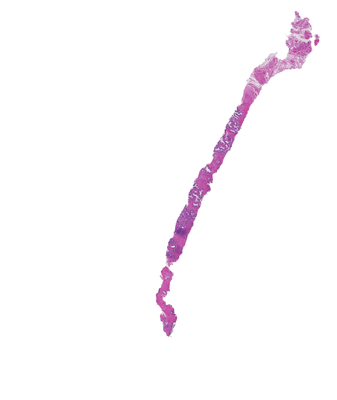

File id: OpenSlide('../data/train_images/005e66f06bce9c2e49142536caf2f6ee.tiff')
Dimensions: (31744, 37632)
Microns per pixel / pixel spacing: 0.452
Number of levels in the image: 3
Downsample factor per level: (1.0, 4.0, 16.0)
Dimensions of levels: ((31744, 37632), (7936, 9408), (1984, 2352))
ISUP grade: 1
Gleason score: 3+3




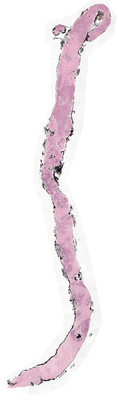

File id: OpenSlide('../data/train_images/00928370e2dfeb8a507667ef1d4efcbb.tiff')
Dimensions: (10752, 36352)
Microns per pixel / pixel spacing: 0.486
Number of levels in the image: 3
Downsample factor per level: (1.0, 4.0, 16.0)
Dimensions of levels: ((10752, 36352), (2688, 9088), (672, 2272))
ISUP grade: 5
Gleason score: 4+5




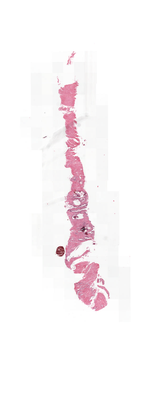

File id: OpenSlide('../data/train_images/007433133235efc27a39f11df6940829.tiff')
Dimensions: (9472, 24320)
Microns per pixel / pixel spacing: 0.486
Number of levels in the image: 3
Downsample factor per level: (1.0, 4.0, 16.0)
Dimensions of levels: ((9472, 24320), (2368, 6080), (592, 1520))
ISUP grade: 0
Gleason score: negative




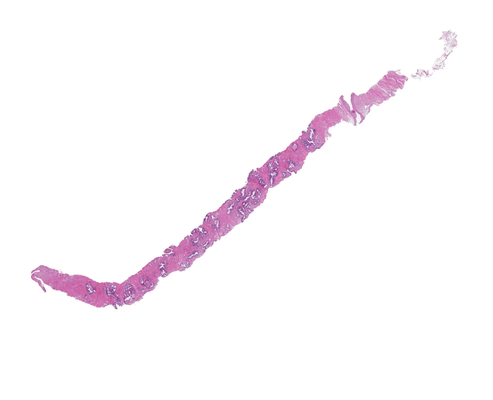

File id: OpenSlide('../data/train_images/024ed1244a6d817358cedaea3783bbde.tiff')
Dimensions: (26891, 21815)
Microns per pixel / pixel spacing: 0.503
Number of levels in the image: 3
Downsample factor per level: (1.0, 4.000498225811406, 16.005841674527478)
Dimensions of levels: ((26891, 21815), (6722, 5453), (1680, 1363))
ISUP grade: 0
Gleason score: 0+0




In [13]:
example_slides = [
    '005e66f06bce9c2e49142536caf2f6ee',
    '00928370e2dfeb8a507667ef1d4efcbb',
    '007433133235efc27a39f11df6940829',
    '024ed1244a6d817358cedaea3783bbde',
]

for case_id in example_slides:
    biopsy = openslide.OpenSlide(os.path.join(IMG_DIR, f'{case_id}.tiff'))
    print_slide_details(biopsy)
    biopsy.close()
    
    # Print the case-level label
    print(f"ISUP grade: {train_df.loc[case_id, 'isup_grade']}")
    print(f"Gleason score: {train_df.loc[case_id, 'gleason_score']}\n\n")

The images above are simply thumbnails of the actual image. Several problems can be observed when using WSI in a deep learning pipeline:

1. The original images are too large to be processed directly. This means that levels and patches have to be used, or else it because infeasible.
2. The image dimensions vary per image. This means that the network solution will have to be flexible enough to process images of various sizes.

The second item might not really be a problem nowadays, but it is still something worth nothing considering the nature of the desired solution.
   
Now, we will be plotting image patches, as well as outlining the visual differences between the data providers.

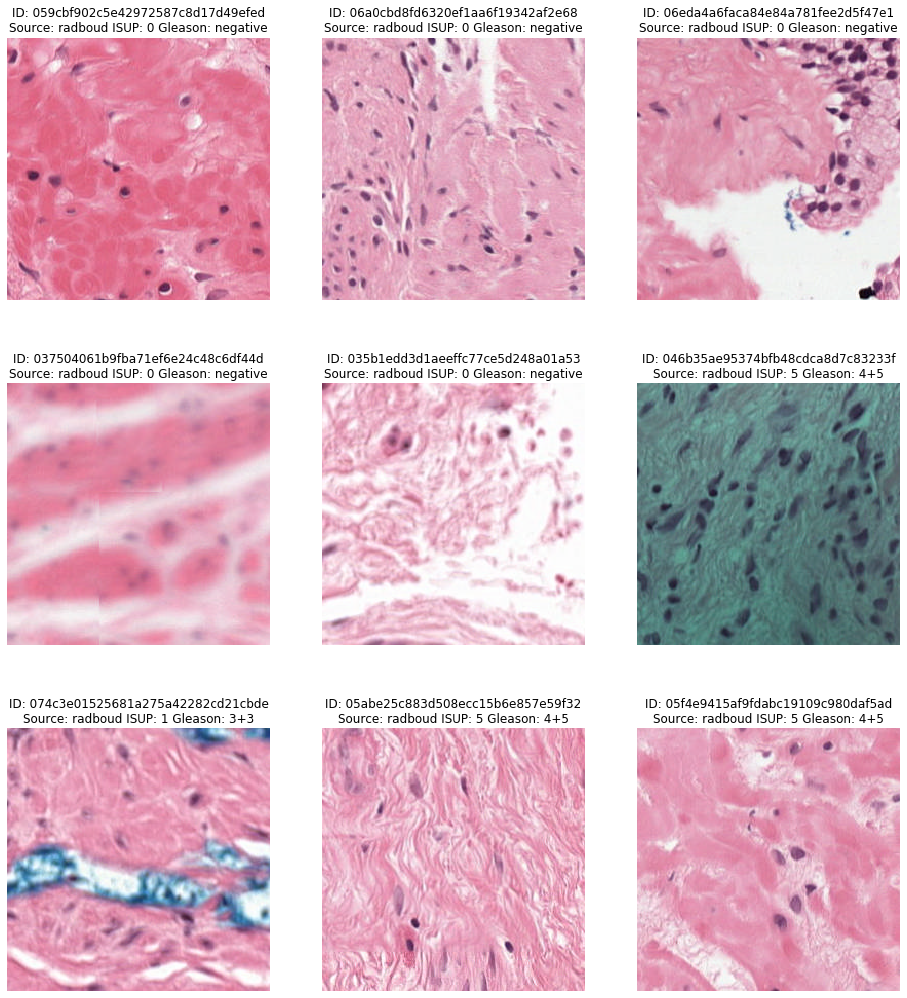

In [14]:
# The previous one show white objects in this coordinate, so I used an example from another notebook.
example_slides2 = [
    '059cbf902c5e42972587c8d17d49efed', '06a0cbd8fd6320ef1aa6f19342af2e68', '06eda4a6faca84e84a781fee2d5f47e1',
    '037504061b9fba71ef6e24c48c6df44d', '035b1edd3d1aeeffc77ce5d248a01a53', '046b35ae95374bfb48cdca8d7c83233f',
    '074c3e01525681a275a42282cd21cbde', '05abe25c883d508ecc15b6e857e59f32', '05f4e9415af9fdabc19109c980daf5ad']  

# patch sizes are 256, 256 at level 0
data_sample = train_df.loc[example_slides2]
display_patches(data_sample, IMG_DIR)


The patch images are 256x256 and are sampled from level 0 (highest resolution). One of the most notable things is that several areas of the patch are different in color. This is not only visible through the various shades of pink and purple. But one of the patches is green (I think due to pen strokes). This could lead to some problems later on, especially if it could be accidentally exploited as a discriminator between ISUP grades.

An example of this phenomenon is already stated above: we know that karolinska provides more contributions to the lower ISUP grades, whereas Radboud provides more examples from ISUP grades > 2. Since WSI's are processed differently across these institutions, the color and image properties can be different. To explore this, we will now compare some of the thumbnail images from karolinska and radboud to get an idea of the color differences.

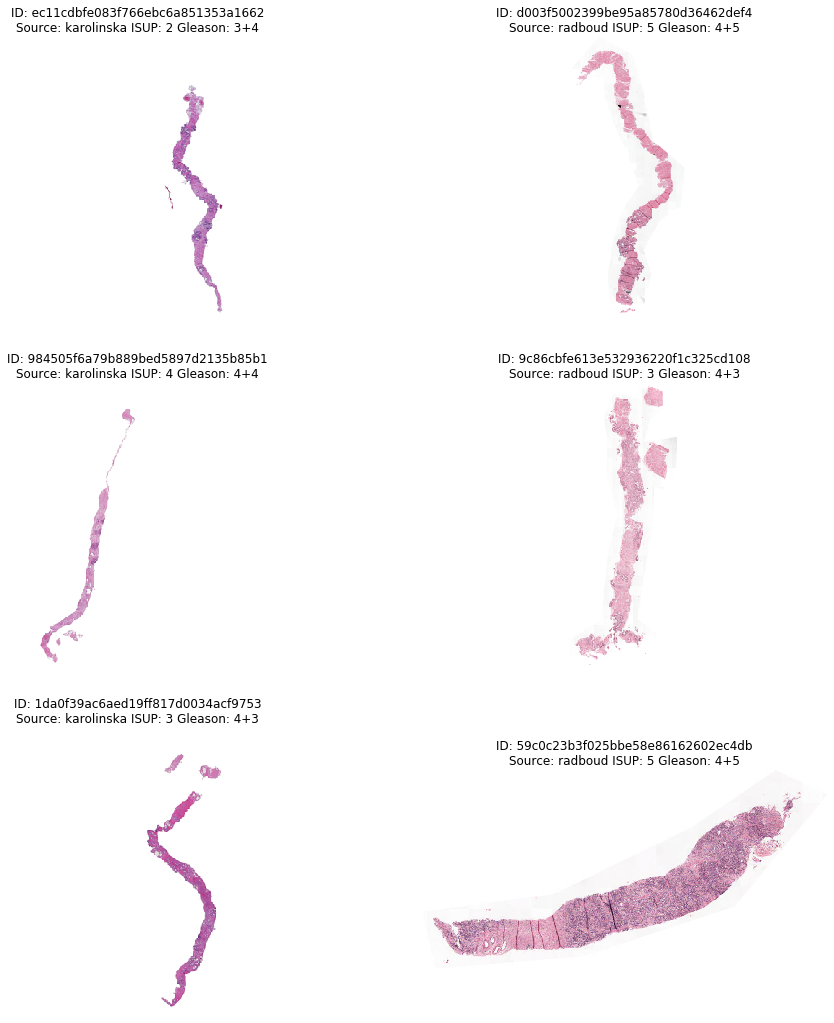

In [15]:
# select a random subset of Radboud and karolinska images from the training df
n_samples = 3
karolinska = train_df[train_df['data_provider']=='karolinska']
karolinska_sample = karolinska.sample(n=n_samples)
radboud = train_df[train_df['data_provider']=='radboud']
radboud_sample = radboud.sample(n=n_samples)
pairwise_plot(karolinska_sample, radboud_sample, IMG_DIR, max_size=(800,400))

For the most part, it seems that the colour distributions between the data providers differ substantially. In general the Karolinska images are darker in colour, whereas the Radboud samples are lighter. To further investigate this, we can make a total histogram distribution between the two data providers.

The way this is done is as follows: we take a number of $N$ samples from both data providers. Then for each image, we compute its per-channel histogram. Finally, all of these histograms are summed together and divided by their respective total number of pixels (to allow for comparison). 
   
**Note:** the white background skews the histogram to have many counts of 255 (white = (255,255,255)). As a result, the histogram becomes uninformative if they are not removed since it will show a single bar containing the white values. As a result, all of the pixels with this value are removed beforehand. Although there can be false positive (non-white) values that are also deleted, it does improve the visualization quite a bit, and the information we lose is only a single bar.

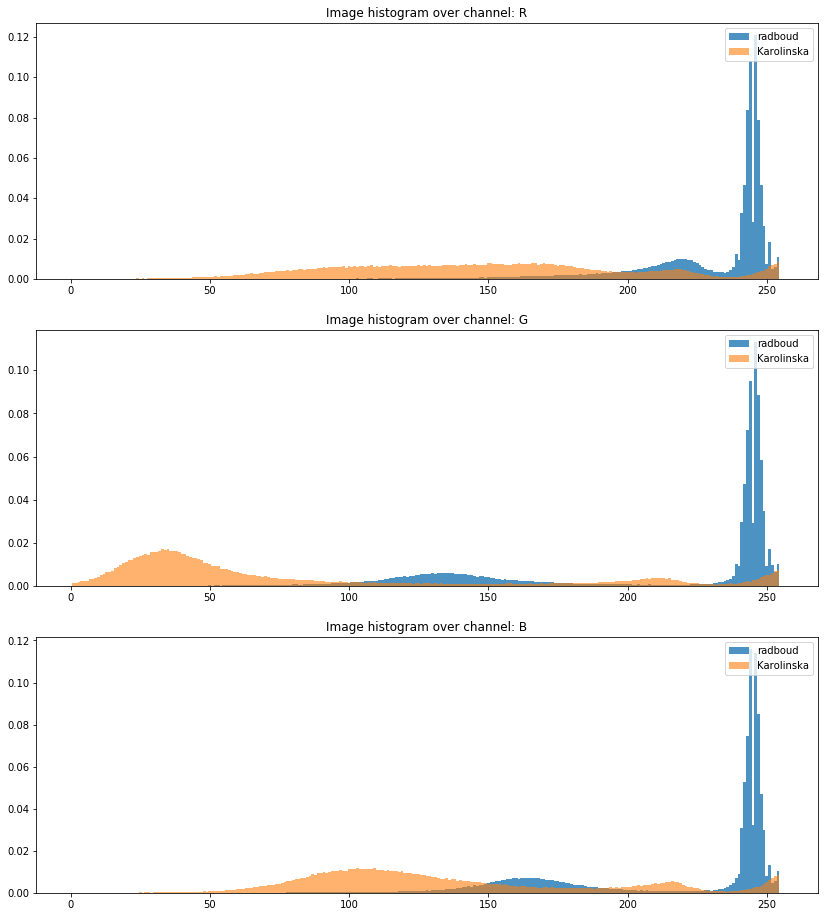

In [17]:
# obtain the histogram (per channel), bin edges, and total pixel count per color channel
# warning: increasing the number of samples can increase computation time substantially
# 5000 constituted a large training time
hist_rad, bin_edges, pixel_count_rad = get_hist(radboud.sample(n=50), level=2, remove_white=True)
hist_kar, bin_edges, pixel_count_kar = get_hist(karolinska.sample(n=50), level=2, remove_white=True)

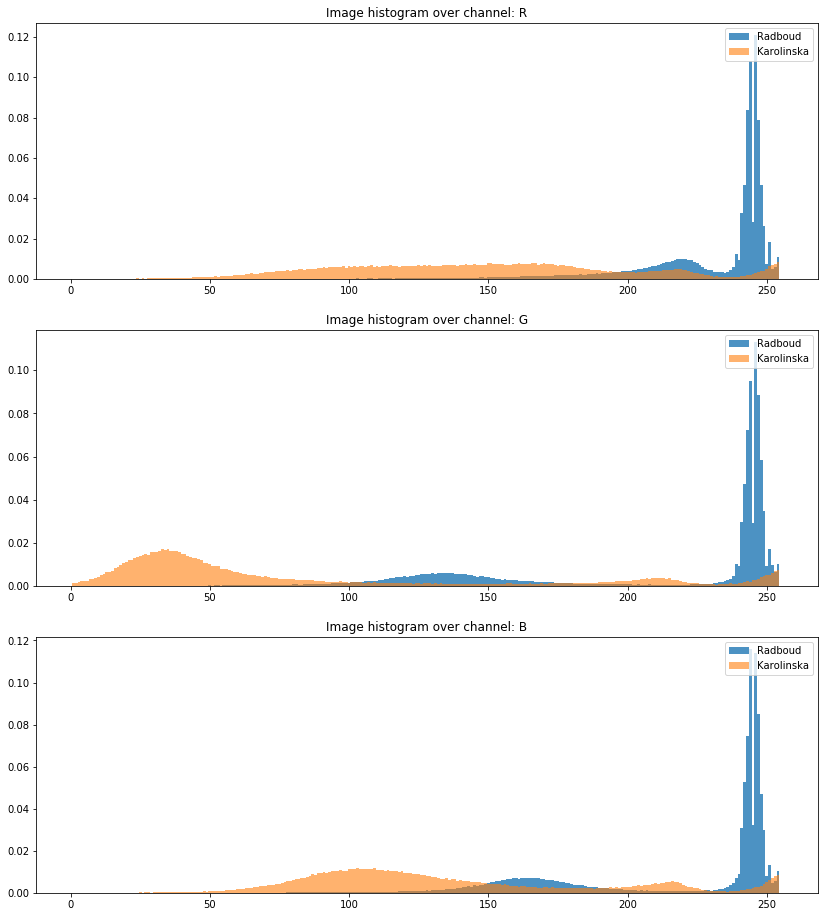

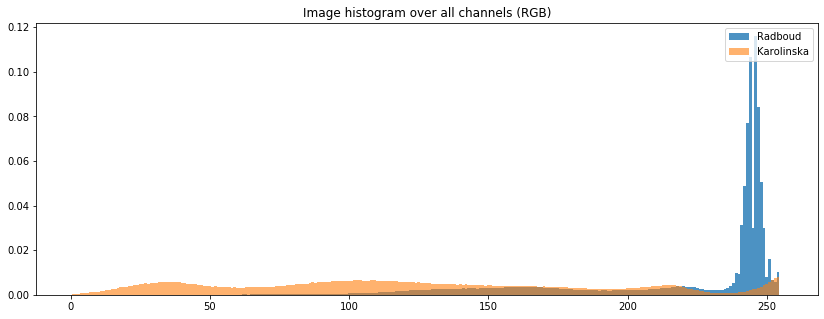

In [33]:
fig, ax = plt.subplots(3,1, figsize=(14,16))

for channel,ch_str in zip([0,1,2], ['R','G','B']):
    ax[channel].bar(bin_edges[:-1], hist_rad[:,channel] / pixel_count_rad[:,channel], width=256./256, label='Radboud', alpha=.8)
    ax[channel].bar(bin_edges[:-1], hist_kar[:,channel] / pixel_count_kar[:,channel], width=256./256, label='Karolinska', alpha=.6)
    ax[channel].set_title(f'Image histogram over channel: {ch_str}')
    ax[channel].legend(loc='upper right')
plt.show()


plt.figure(figsize=(14,5))
plt.bar(bin_edges[:-1], np.sum(hist_rad,axis=1) / np.sum(pixel_count_rad,axis=1), width=256./256, label='Radboud', alpha=.8)
plt.bar(bin_edges[:-1], np.sum(hist_kar,axis=1) / np.sum(pixel_count_kar,axis=1), width=256./256, label='Karolinska', alpha=.6)
plt.legend(loc='upper right')

plt.title(f'Image histogram over all channels (RGB)')
plt.show()

### image distribution conclusions [1]
The histograms of the color channels show us that there is a substantial difference between between the Karolinska and radboud samples. The radboud distribution seems to be fairly centered at the far end of the colour spectrum, having high counts in  each channel with pixel values over 200. The Karolinska samples on the other hand seem to differ among each colour channel, and emit a higher variation.
   
All in all, the color distributions of both providers vary quite a bit, and this should not be taken lightly. More specifically, we know that Karolinska offers more samples for ISUP grades < 2, and Radboud has more samples in ISUP grades > 2. This could mean that, if left untreated, the models might learn unwanted features, learning that Karolinksa-like colour distributions have a higher probability of having an ISUP grade of <2, and Radboud colour distributions having an ISUP grade of >2. As this should not be the case, and is entirely unrelated from ISUP grades, this behaviour should be prevented.
   
There are several ways to incorporate this into the training process:
* Histogram equalization: Match the histograms to turn one color distribution into the other
* Stain color normalization: Aims to match training and test color distributions in order to reduce stain variation
* Color augmentation: apply extensive data augmentation, such that the network becomes stain-invariant.
   
Considering we are using machine learning, and since neural networks are flexible, one should in my opinion aim to use the final approach: if your model becomes invariant to the staining process, it can be used in a wide variety of research labs, without having to perform case-specific normalization of histogram equalization techniques. That being said, it can be difficult to find the right parameters for image enhancement and variations, such the augmented distribution covers the span of possible stain variations.

### Labels and image overlay 
The final hurdle is to incorporate the masks into the pictures. Although these masks are optional, they can still provide some extra insights. The only caveat is that many of the segmentations are generated through semi-supervised models, meaning that there might be false positives, or false negatives.

Apart from the slide-level label (present in the csv file), almost all slides in the training set have an associated mask with additional label information. These masks directly indicate which parts of the tissue are healthy and which are cancerous. The information in the masks differ from the two centers:
   
* Radboudumc: Prostate glands are individually labelled. Valid values are:
    * 0: background (non tissue) or unknown   
    * 1: stroma (connective tissue, non-epithelium tissue)   
    * 2: healthy (benign) epithelium"   
    * 3: cancerous epithelium (Gleason 3)   
    * 4: cancerous epithelium (Gleason 4)   
    * 5: cancerous epithelium (Gleason 5)  

* Karolinska: Regions are labelled. Valid values:   
    * 0: background (non tissue) or unknown   
    * 1: benign tissue (stroma and epithelium combined)   
    * 2: cancerous tissue (stroma and epithelium combined)   
    
The label masks of Radboudumc were semi-automatically generated by several deep learning algorithms, contain noise, and can be considered as weakly-supervised labels. The label masks of Karolinska were semi-autotomatically generated based on annotations by a pathologist.   

The label masks are stored in an RGB format so that they can be easily opened by image readers. The label information is stored in the red (R) channel, the other channels are set to zero and can be ignored. As with the slides itself, the label masks can be opened using OpenSlide.

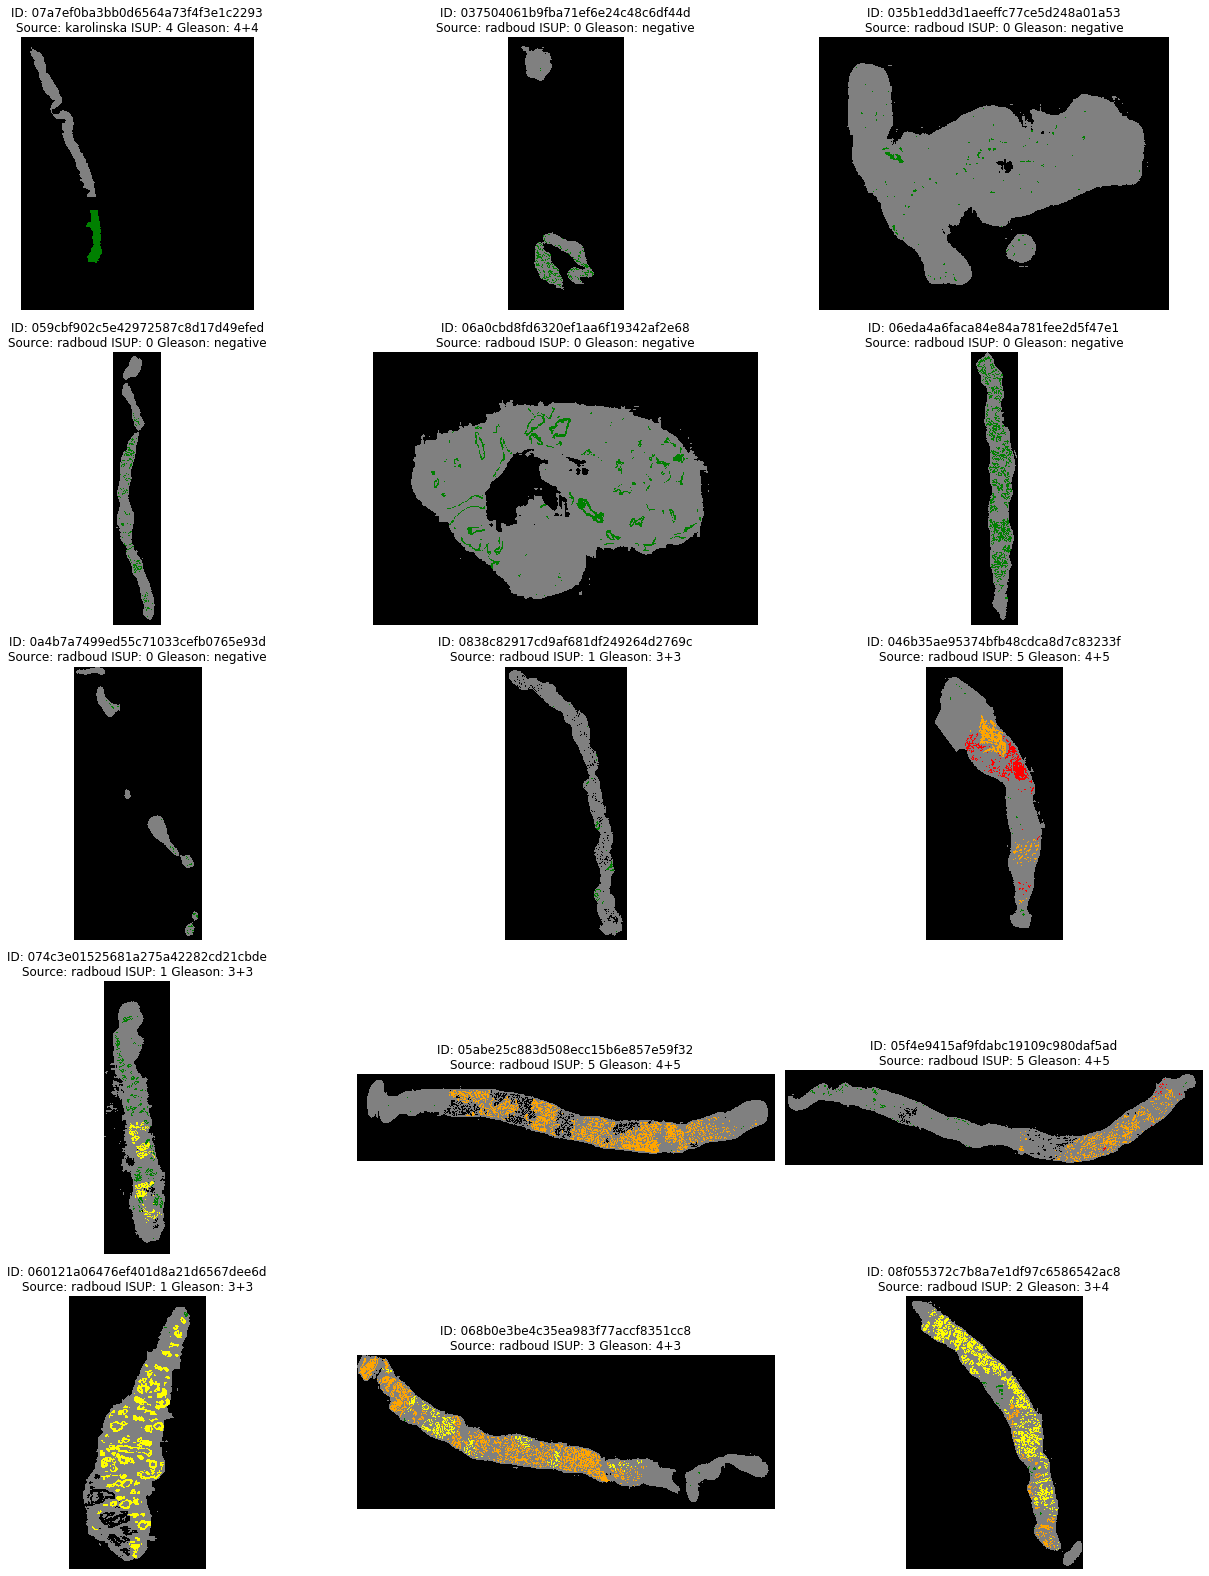

In [16]:
# we will work with these examples for now
images = [
    '07a7ef0ba3bb0d6564a73f4f3e1c2293',
    '037504061b9fba71ef6e24c48c6df44d',
    '035b1edd3d1aeeffc77ce5d248a01a53',
    '059cbf902c5e42972587c8d17d49efed',
    '06a0cbd8fd6320ef1aa6f19342af2e68',
    '06eda4a6faca84e84a781fee2d5f47e1',
    '0a4b7a7499ed55c71033cefb0765e93d',
    '0838c82917cd9af681df249264d2769c',
    '046b35ae95374bfb48cdca8d7c83233f',
    '074c3e01525681a275a42282cd21cbde',
    '05abe25c883d508ecc15b6e857e59f32',
    '05f4e9415af9fdabc19109c980daf5ad',
    '060121a06476ef401d8a21d6567dee6d',
    '068b0e3be4c35ea983f77accf8351cc8',
    '08f055372c7b8a7e1df97c6586542ac8'
]
   
display_masks(images, train_df, MASK_DIR)

The masks shown above are from both data providers. The different colors outside from black and grey depict cancerous tissue. The next step is to show the masks being compared side to side with their original tissue sample, and then to overlay them

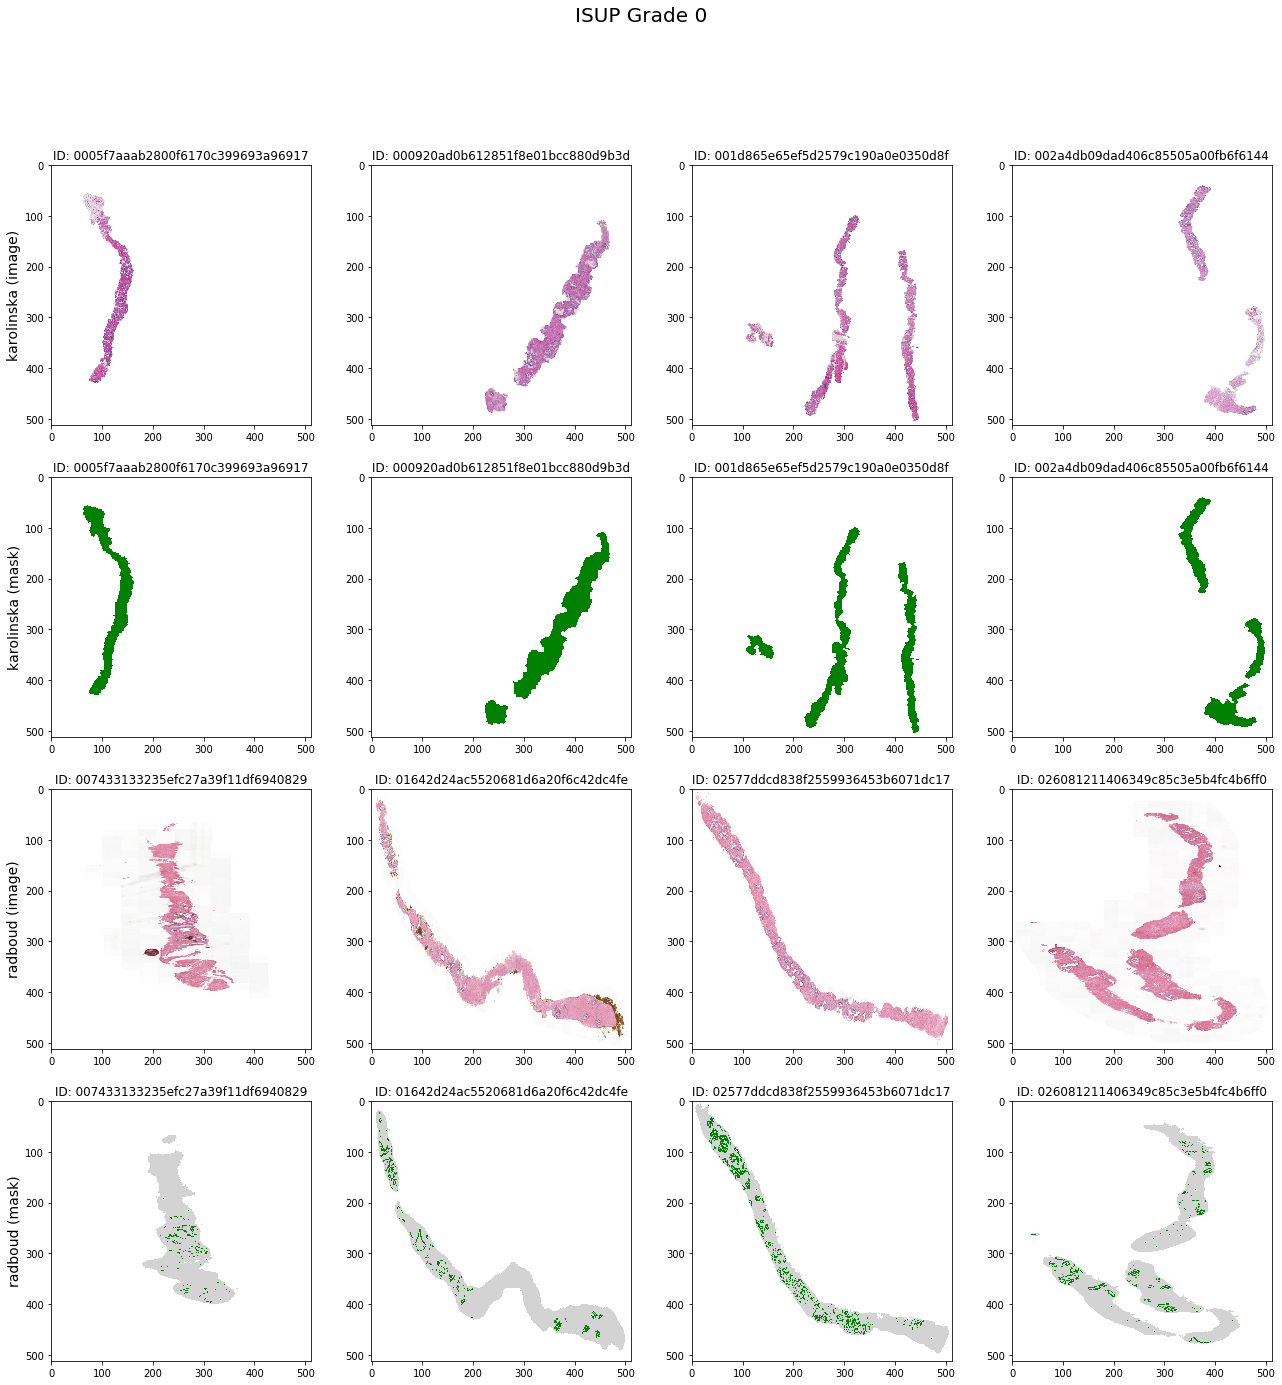

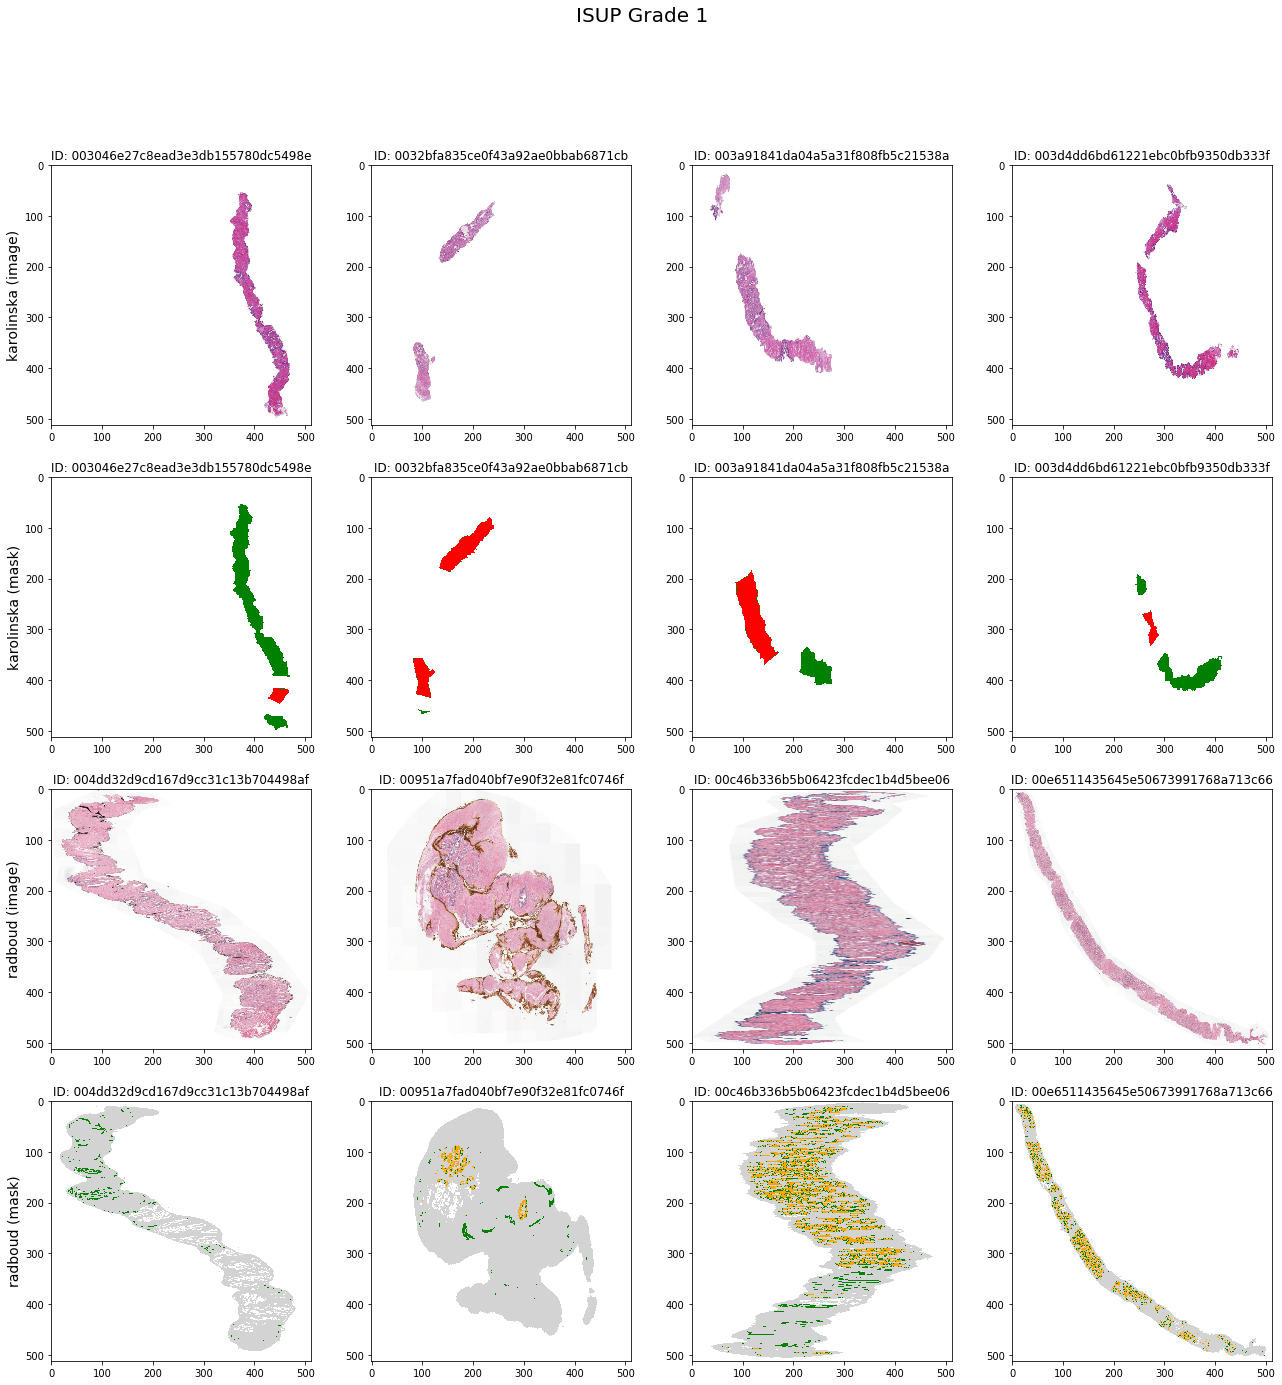

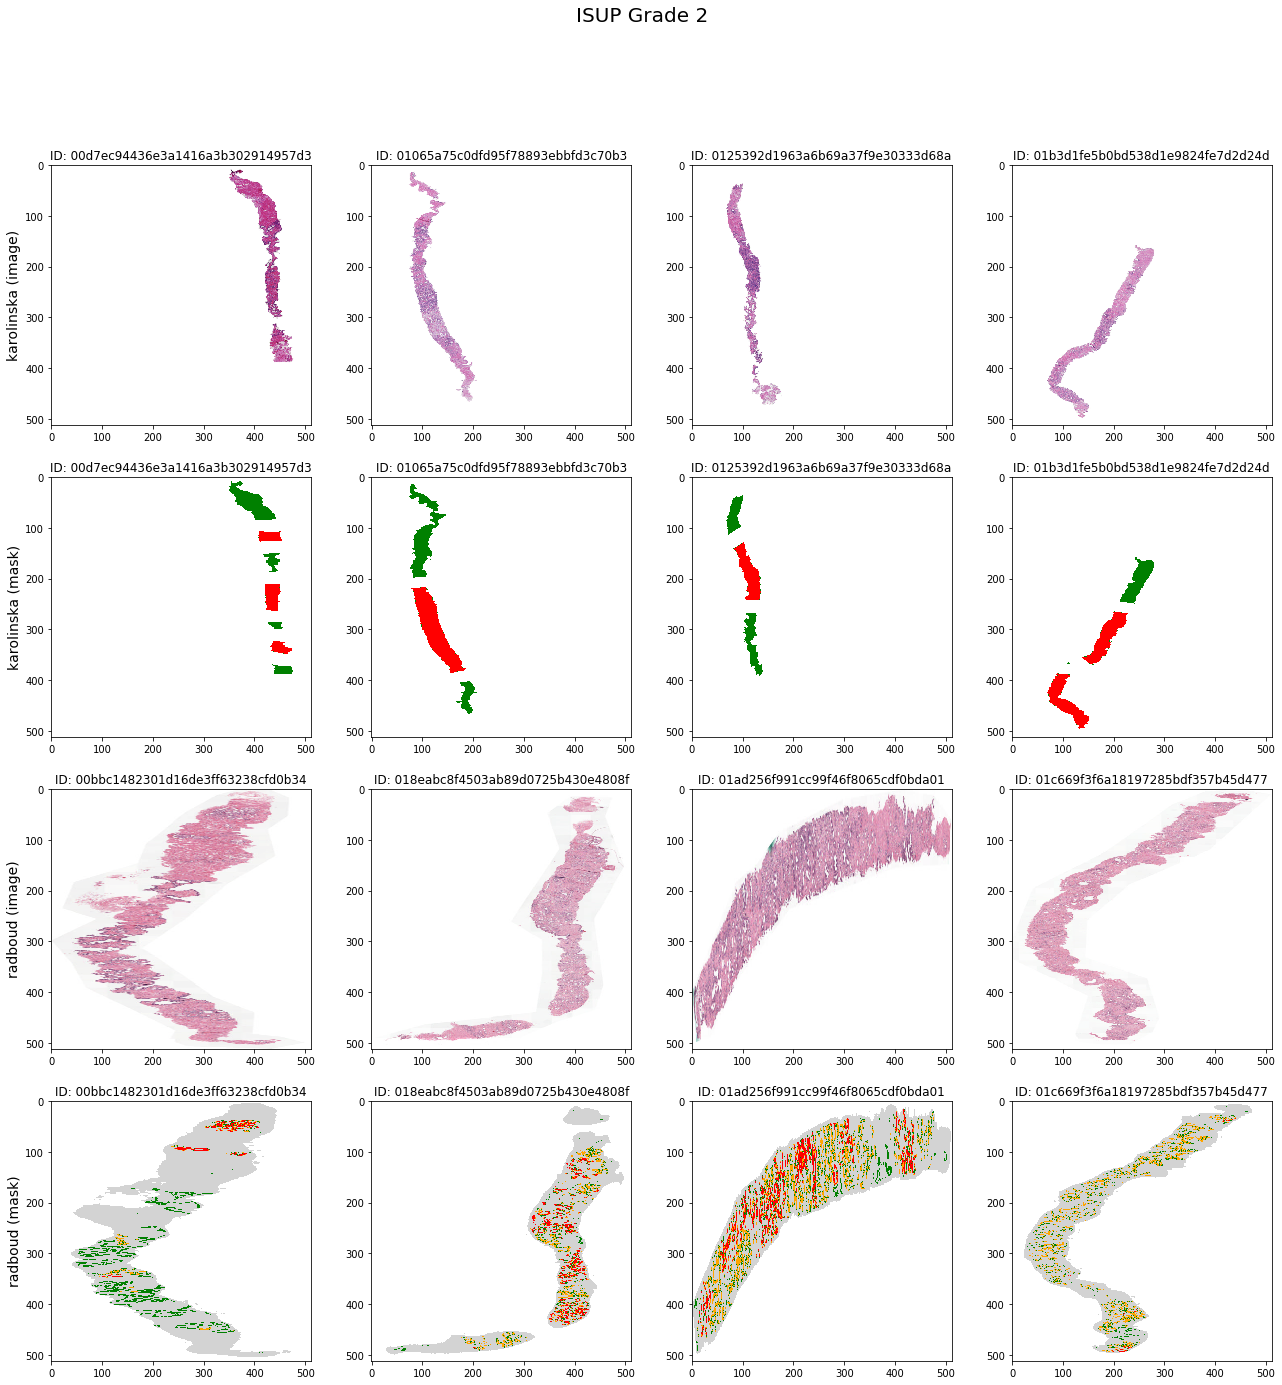

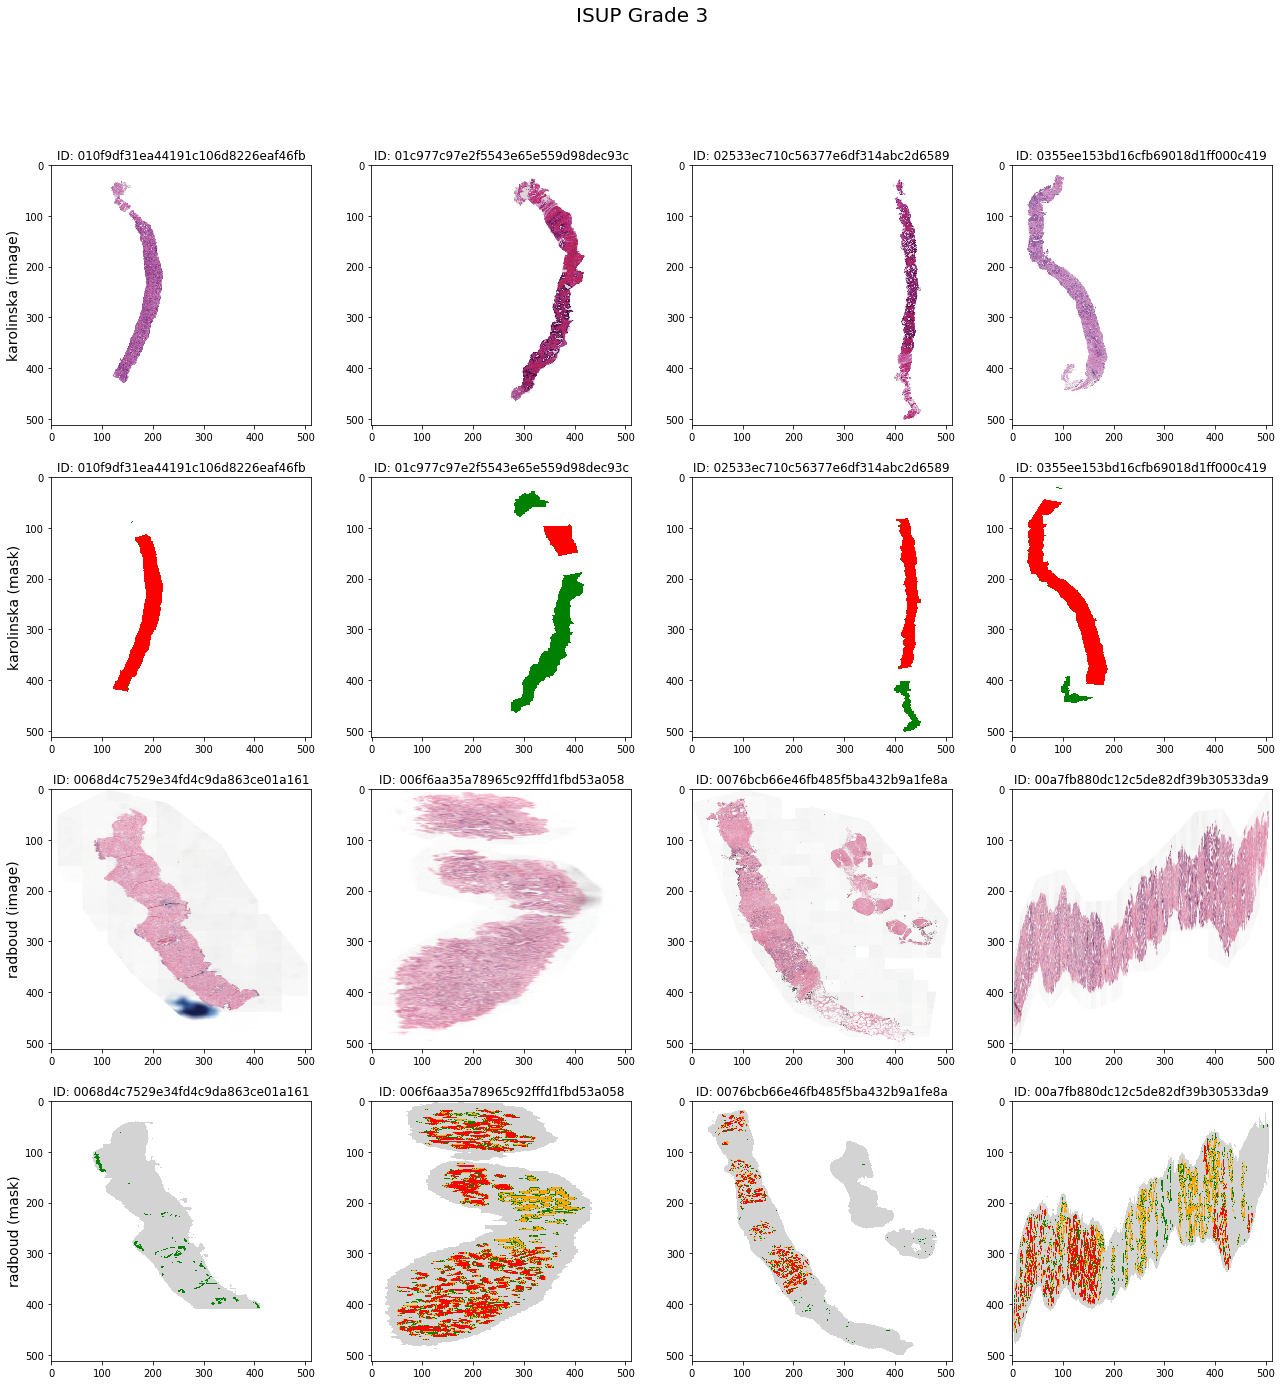

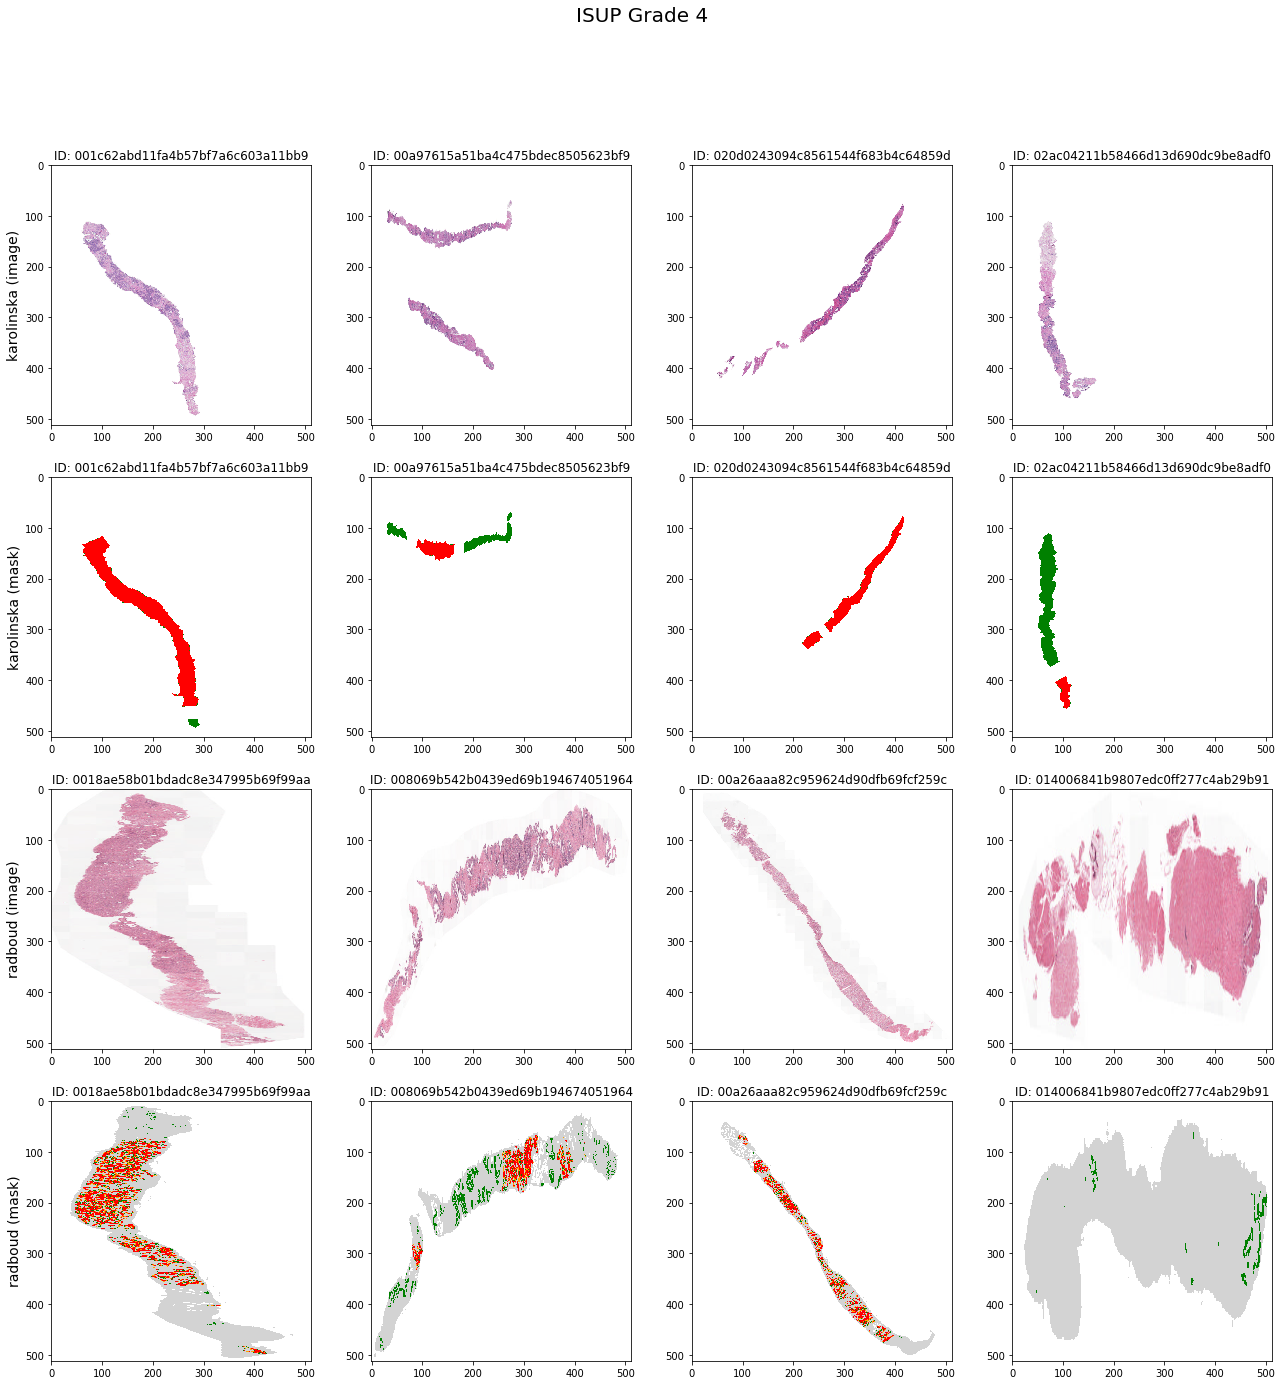

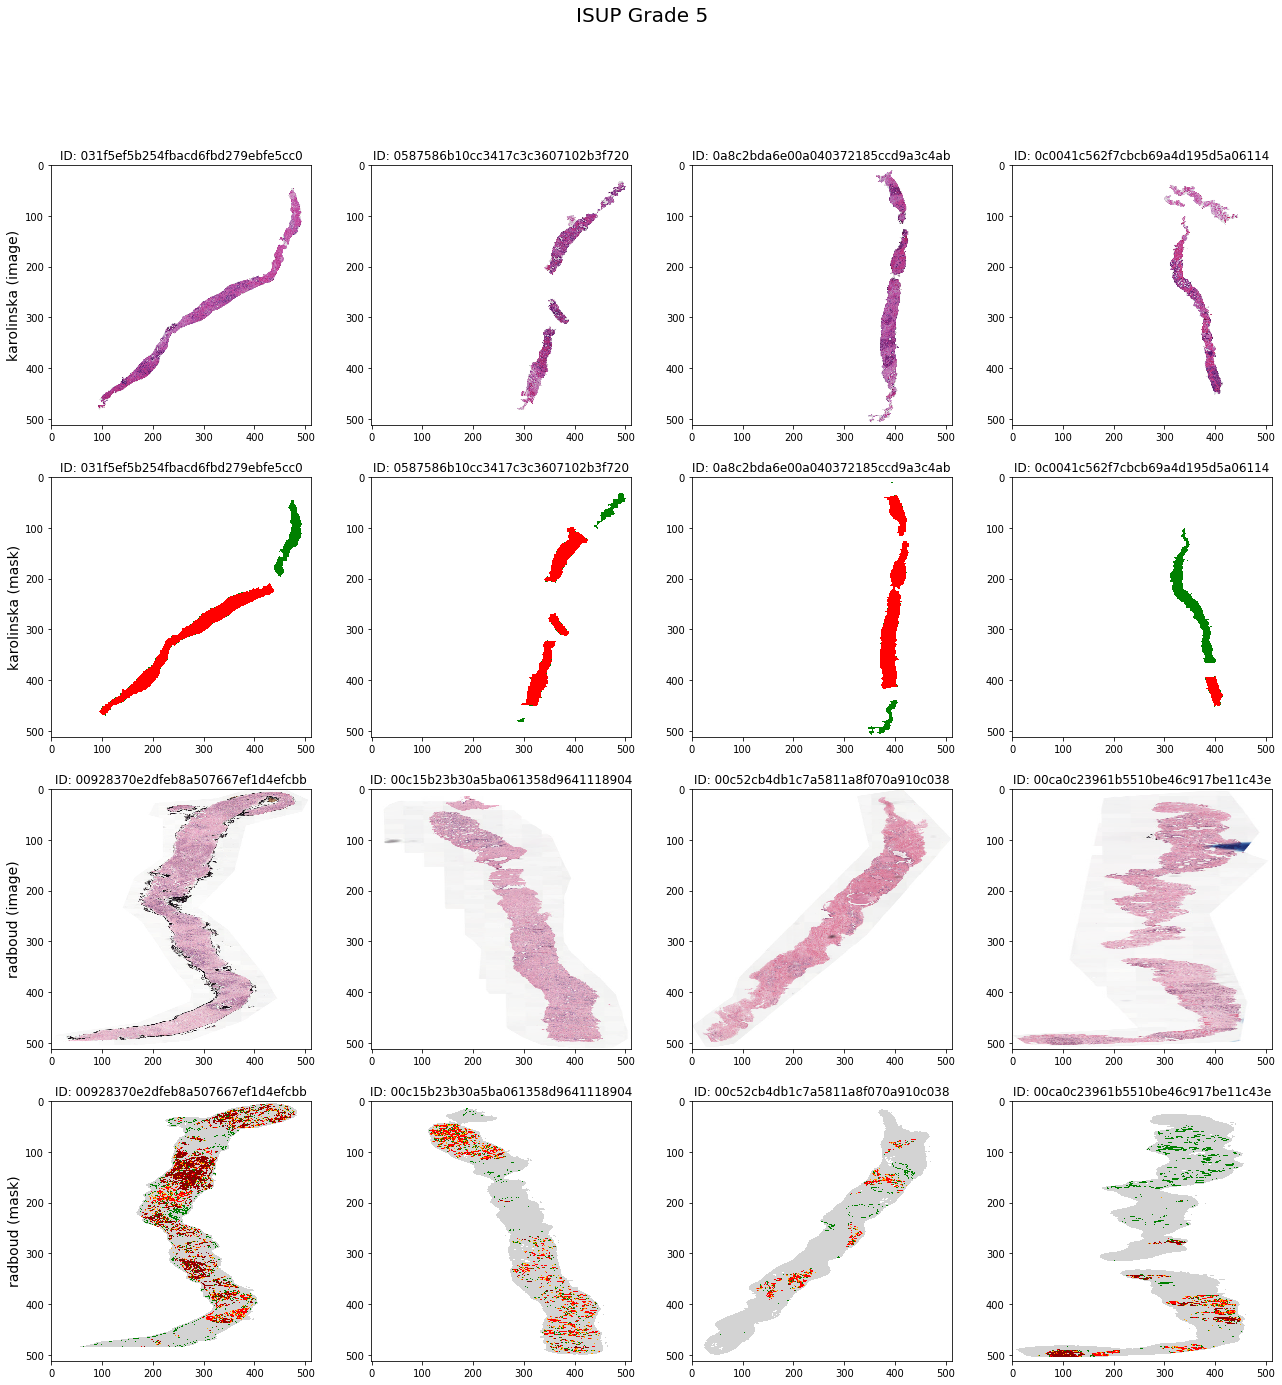

In [19]:
labels = []
data_providers = ['karolinska', 'radboud']

for grade in range(train_df.isup_grade.nunique()):
    fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(22, 22))

    for i, row in enumerate(ax):
        idx = i//2
        temp = train_df[(train_df.isup_grade == grade) & (train_df.data_provider == data_providers[idx])].index.to_series().head(4).reset_index(drop=True)
        if i%2 < 1:
            labels.append(f'{data_providers[idx]} (image)')
            for j, col in enumerate(row):
                col.imshow(load_and_resize_image(temp[j], IMG_DIR))
                col.set_title(f"ID: {temp[j]}")
                
        else:
            labels.append(f'{data_providers[idx]} (mask)')
            for j, col in enumerate(row):
                if data_providers[idx] == 'radboud':
                    col.imshow(load_and_resize_mask(temp[j], MASK_DIR), 
                               cmap = colors.ListedColormap(['white', 'lightgrey', 'green', 'orange', 'red', 'darkred']), 
                               norm = colors.Normalize(vmin=0, vmax=5, clip=True))
                else:
                    col.imshow(load_and_resize_mask(temp[j], MASK_DIR), 
                           cmap = colors.ListedColormap(['white', 'green', 'red']), 
                           norm = colors.Normalize(vmin=0, vmax=2, clip=True))
                    
                gleason_score = train_df.loc[temp[j], 'gleason_score']
                col.set_title(f"ID: {temp[j]}")
        
    for row, r in zip(ax[:,0], labels):
        row.set_ylabel(r, rotation=90, size='large', fontsize=14)

    plt.suptitle(f'ISUP Grade {grade}', fontsize=20)
    plt.show()

This figure above shows the original tissue sample and beneath them their masks. The next step is to overlay them so we can see where the mask is generated on the original tissue.

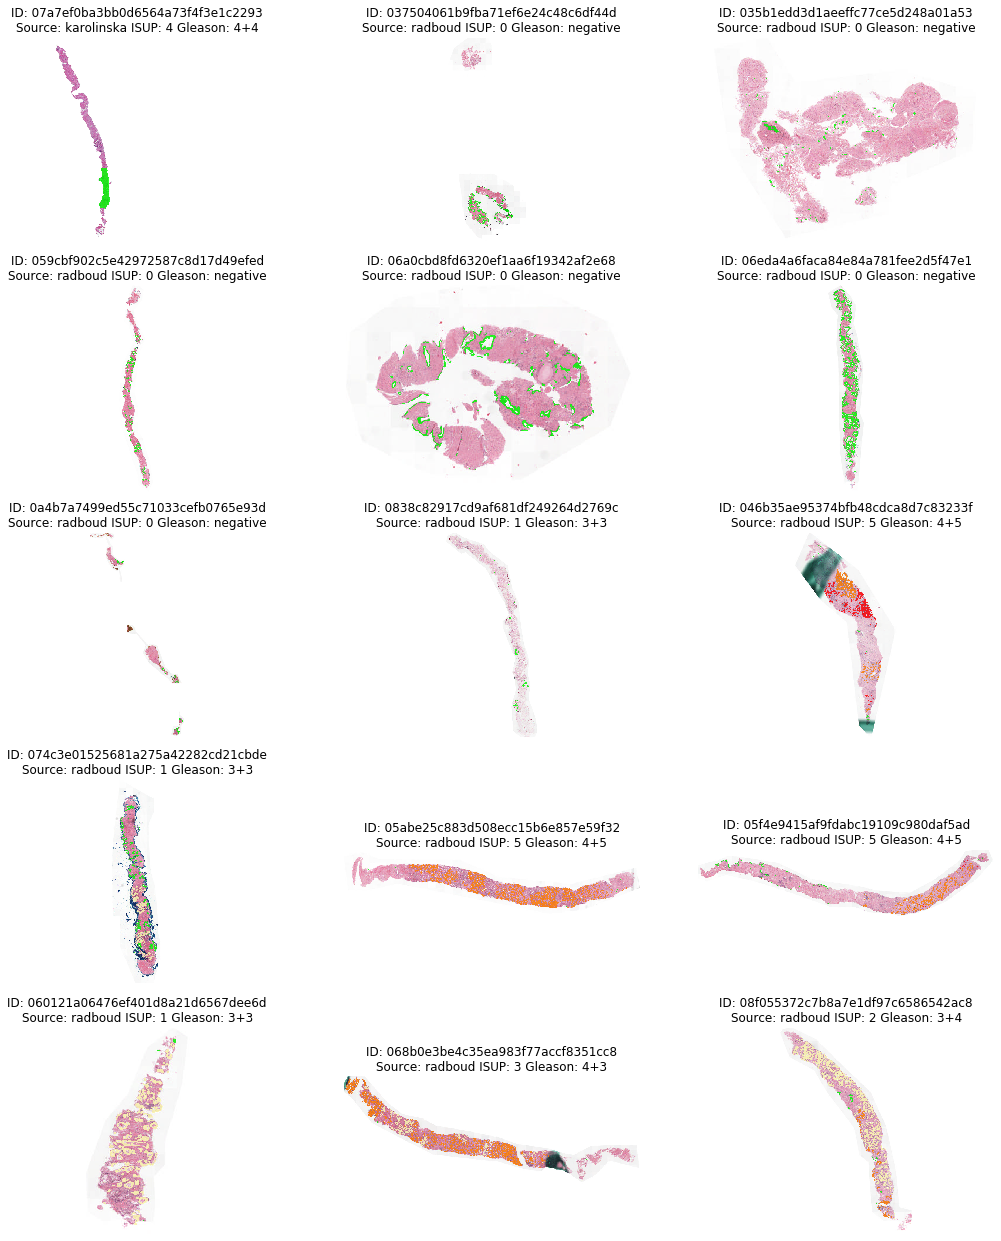

In [31]:
overlay_mask_on_slide(images, IMG_DIR, MASK_DIR)

The overlay shows the cancerous cells overlayed on the original tissue. The sample can be a mix of healthy and unhealthy tissue. We also observe some strange color deformation, which are pen marks. Let's explore these furhter.

### Exploring pen marked images

It is mentioned here that in training dataset, there are few images with pen markers on them. The organizers left us with a Note as described below.

>Note that slightly different procedures were in place for the images used in the test set than the training set. Some of the training set images have stray pen marks on them, but the test set slides are free of pen marks.

Let's take a look on few of these images.

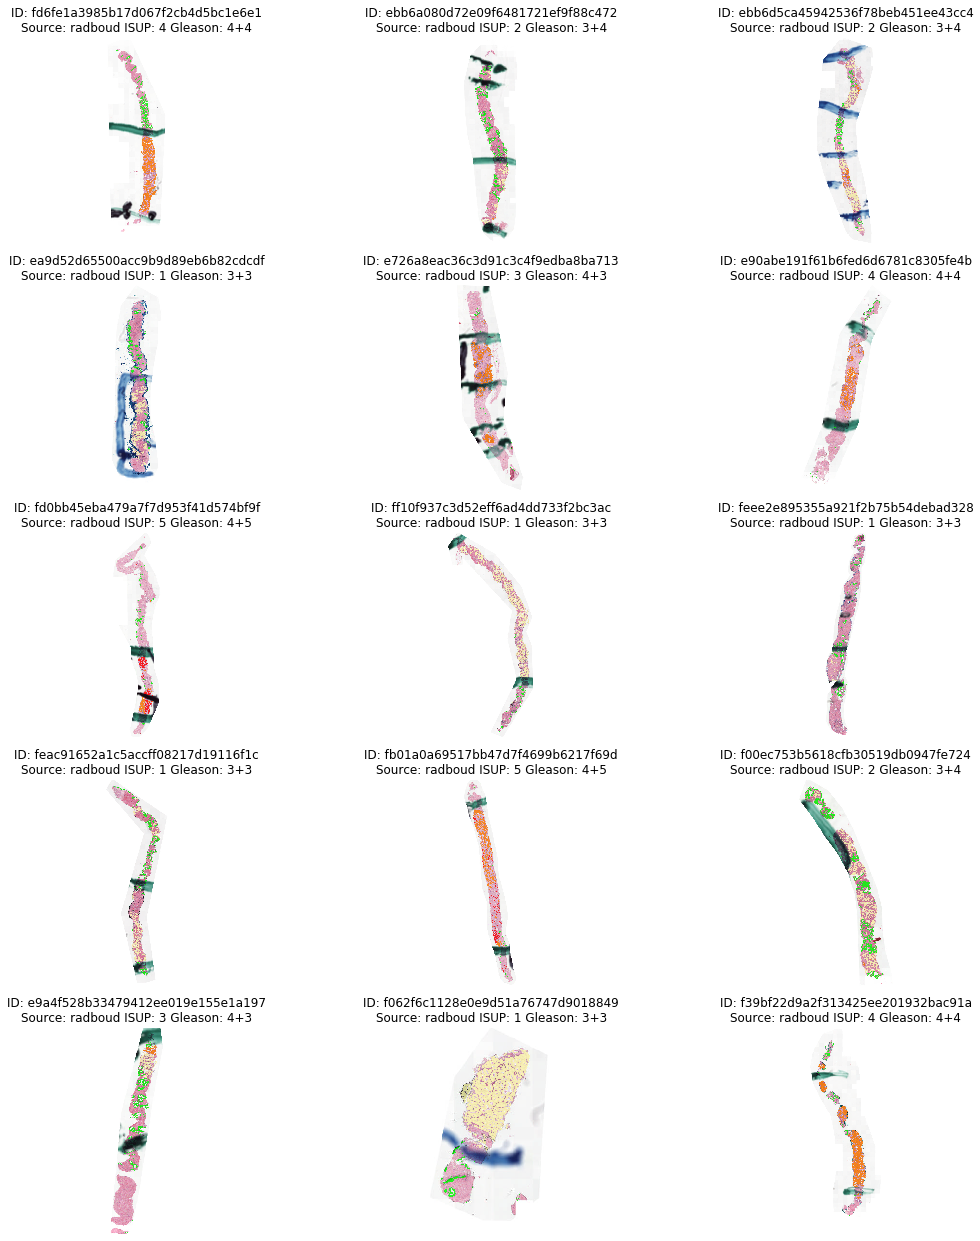

In [33]:
pen_marked_images = [
    'fd6fe1a3985b17d067f2cb4d5bc1e6e1',
    'ebb6a080d72e09f6481721ef9f88c472',
    'ebb6d5ca45942536f78beb451ee43cc4',
    'ea9d52d65500acc9b9d89eb6b82cdcdf',
    'e726a8eac36c3d91c3c4f9edba8ba713',
    'e90abe191f61b6fed6d6781c8305fe4b',
    'fd0bb45eba479a7f7d953f41d574bf9f',
    'ff10f937c3d52eff6ad4dd733f2bc3ac',
    'feee2e895355a921f2b75b54debad328',
    'feac91652a1c5accff08217d19116f1c',
    'fb01a0a69517bb47d7f4699b6217f69d',
    'f00ec753b5618cfb30519db0947fe724',
    'e9a4f528b33479412ee019e155e1a197',
    'f062f6c1128e0e9d51a76747d9018849',
    'f39bf22d9a2f313425ee201932bac91a',
]

overlay_mask_on_slide(pen_marked_images, IMG_DIR, MASK_DIR)

### Exploring other image characteristics

Taken from https://www.kaggle.com/gpreda/panda-challenge-starting-eda.
Finally we can extract some other image and mask characteristics, such as spacings and width/height distributions.

This might be important if one of the characteristics is skewed in favor of certain ISUP grades. We start by adding the image width, height, and spacing to the train_df variable


In [54]:
import time
start_time = time.time()
slide_dimensions, spacings, level_counts = [], [], []

for image_id in train_df.index.to_series():
    image = str(image_id)+'.tiff'
    image_path = os.path.join(IMG_DIR,image)
    slide = openslide.OpenSlide(image_path)
    spacing = 1 / (float(slide.properties['tiff.XResolution']) / 10000)
    slide_dimensions.append(slide.dimensions)
    spacings.append(spacing)
    level_counts.append(slide.level_count)
    slide.close()
    del slide

train_df['width']  = [i[0] for i in slide_dimensions]
train_df['height'] = [i[1] for i in slide_dimensions]
train_df['spacing'] = spacings
train_df['level_count'] = level_counts

end_time = time.time()
print(f"Total processing time: {round(end_time - start_time,2)} sec.")

Total processing time: 75.27 sec.


In [41]:
train_df.head()

data_provider  isup_grade gleason_score  \
image_id                                                                   
0005f7aaab2800f6170c399693a96917    karolinska           0           0+0   
000920ad0b612851f8e01bcc880d9b3d    karolinska           0           0+0   
0018ae58b01bdadc8e347995b69f99aa       radboud           4           4+4   
001c62abd11fa4b57bf7a6c603a11bb9    karolinska           4           4+4   
001d865e65ef5d2579c190a0e0350d8f    karolinska           0           0+0   

                                  width  height   spacing  level_count  
image_id                                                                
0005f7aaab2800f6170c399693a96917  27648   29440  0.452018            3  
000920ad0b612851f8e01bcc880d9b3d  15360   13312  0.452018            3  
0018ae58b01bdadc8e347995b69f99aa   5888   25344  0.486188            3  
001c62abd11fa4b57bf7a6c603a11bb9  23904   28664  0.503198            3  
001d865e65ef5d2579c190a0e0350d8f  28672   34560  0.452018            3

In [42]:
print(f" level count: {train_df.level_count.nunique()}")
print(f" spacing: {train_df.spacing.nunique()}")

 level count: 1
 spacing: 3


### Spacing/scaling
First we can see how the images vary through spacing. The spacing is related to scale 

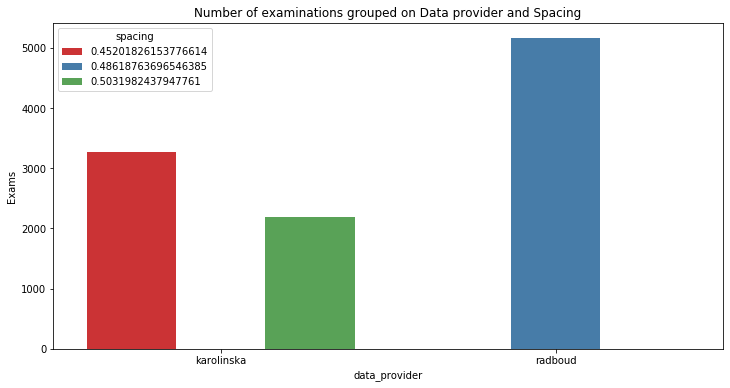

In [43]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6)) 
tmp = train_df.groupby('data_provider')['spacing'].value_counts() 
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index() 
sns.barplot(ax=ax,x = 'data_provider', y='Exams',hue='spacing',data=df, palette='Set1') 
plt.title("Number of examinations grouped on Data provider and Spacing") 
plt.show()

We can see there are 3 different spacing levels. This means that there is not only a difference in the spacings between the two data providers, but also a difference in spacing within the Karolinska dataset. This could be informative (as it relates to scales, and CNN architectures are not scale invariant).

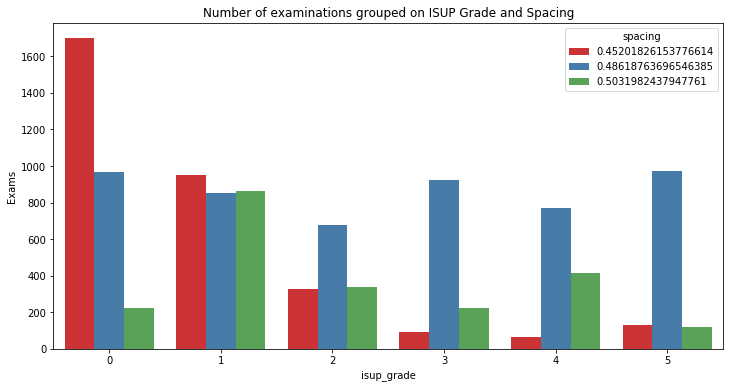

In [44]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6)) 
tmp = train_df.groupby('isup_grade')['spacing'].value_counts() 
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index() 
sns.barplot(ax=ax,x = 'isup_grade', y='Exams',hue='spacing',data=df, palette='Set1') 
plt.title("Number of examinations grouped on ISUP Grade and Spacing") 
plt.show()

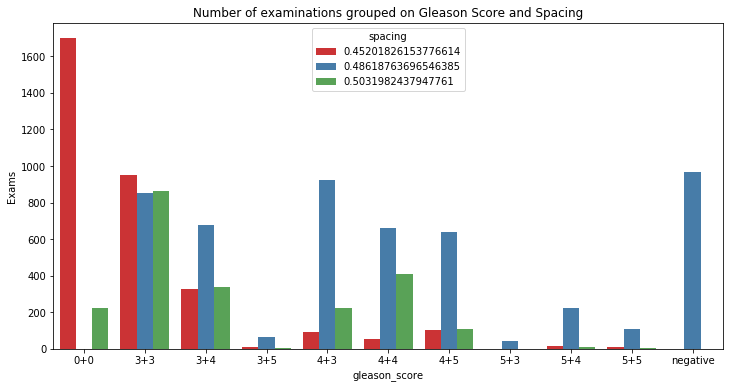

In [45]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6)) 
tmp = train_df.groupby('gleason_score')['spacing'].value_counts() 
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index() 
sns.barplot(ax=ax,x = 'gleason_score', y='Exams',hue='spacing',data=df, palette='Set1') 
plt.title("Number of examinations grouped on Gleason Score and Spacing") 
plt.show()

### Image width/height distributions
The image widths and heights can also be compared to see how the data providers differ in this area.

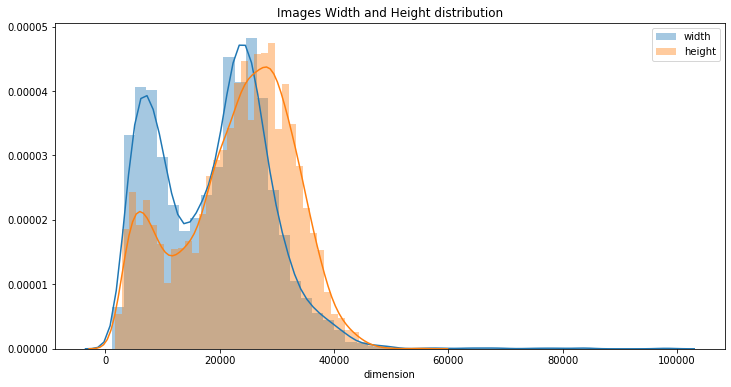

In [46]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6)) 
sns.distplot(train_df['width'], kde=True, label='width')
sns.distplot(train_df['height'], kde=True, label='height')
plt.xlabel('dimension')
plt.title('Images Width and Height distribution')
plt.legend()
plt.show()

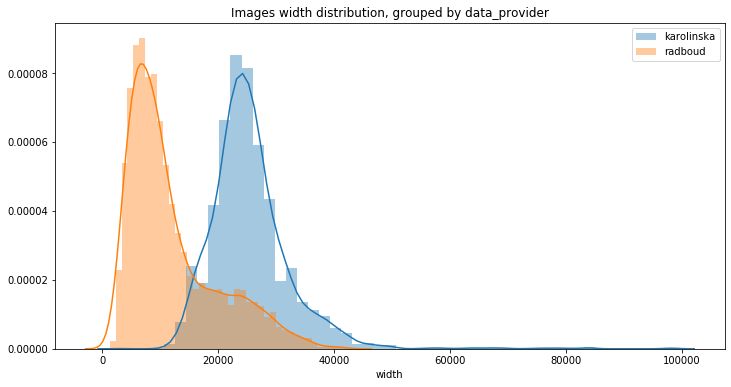

In [48]:
plot_distribution_grouped('width', 'data_provider')

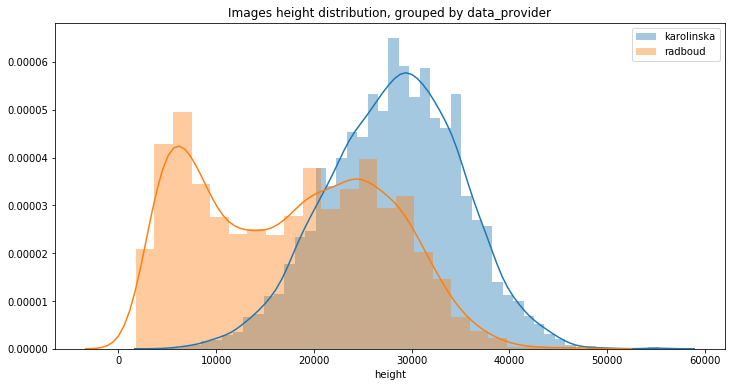

In [49]:
plot_distribution_grouped('height', 'data_provider')

In general, the Radboud samples seem to be larger. However, this does not have a direct effect on the performance of the models we can build.

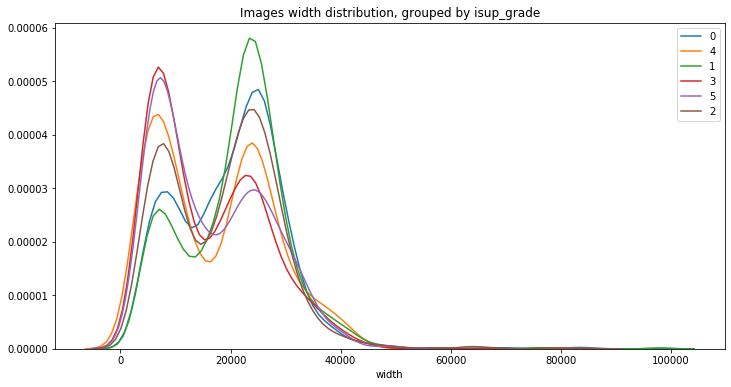

In [50]:
plot_distribution_grouped('width', 'isup_grade', False)

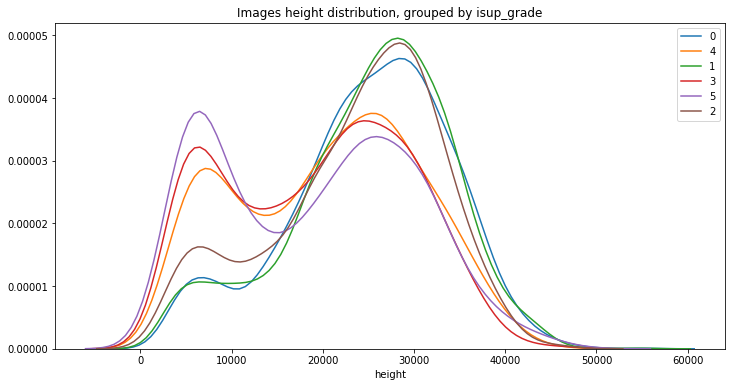

In [51]:
plot_distribution_grouped('height', 'isup_grade', False)

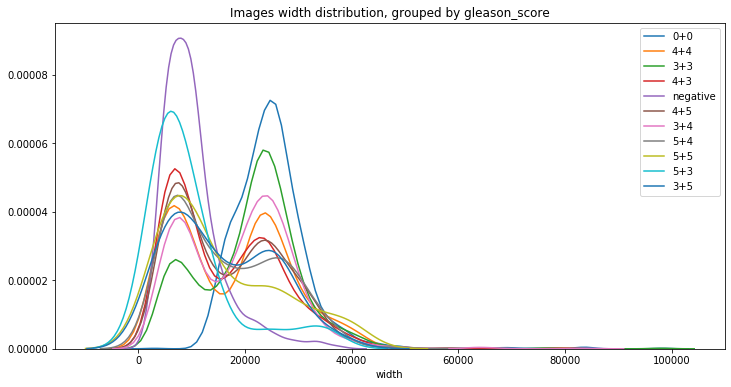

In [52]:
plot_distribution_grouped('width', 'gleason_score', False)

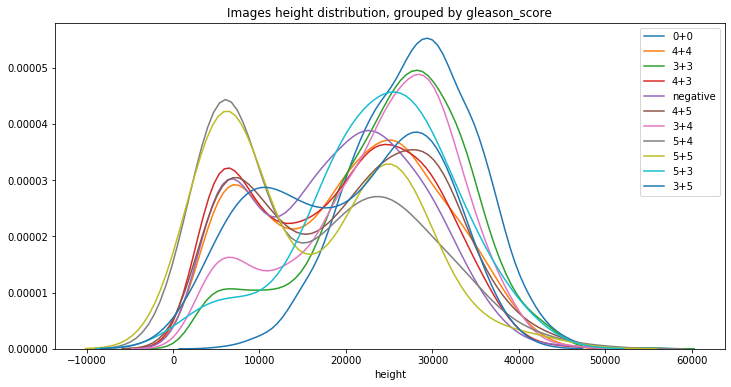

In [53]:
plot_distribution_grouped('height', 'gleason_score', False)

## Conclusions 

Over the course of this notebook, we have investigated several properties of the dataset with respect to the level distribution, image properties, and mask properties.

We will now summarize them and formulate the main targets for the implementation of a pipeline.


Following the label distributions, we can come up with the following conclusions

* Although there are roughly the same amount of examples per data provider, there is still an imbalance
    * There are more examples for ISUP grades [0,1] in total
    * Karolinska contributes more to ISUP grades [0,1], whereas Radboud contributes more to [3,4,5]. ISUP grade [2] is balanced
* Looking at color distributions, the two providers differ substantially, where the Radboud samples are centered at the far right of the histogram, and Karolinska samples are more spread throughout. Bringing them closer together through normalization or augmentation is a key factor
* There are different levels of spacing. No idea yet whether this really matters or not.
* The images from Radboud and Karolinska have different width/height distributions, probably does not matter too much


### Things to think about

* How to properly weigh classes.
* How to efficiently process images (there is alot of white background)
* The colour distributions are too far apart, yielding an unwanted discriminatory factor in the training set. Either use color augmentation or normalization.
* Should we use masks (and how)
* Other data providers?


**Note that slightly different procedures were in place for the images used in the test set than the training set. Some of the training set images have stray pen marks on them, but the test set slides are free of pen marks.**